<a href="https://colab.research.google.com/github/pmopedro/computational-chess/blob/pedro/notebooks/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
import joblib

In [2]:
!pip install chess
import chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
test_folder = './gdrive/MyDrive/comp_chess/data/'
test_info = test_folder + 'games_positions.csv'

df_test = pd.read_csv(test_info)

<Axes: ylabel='Density'>

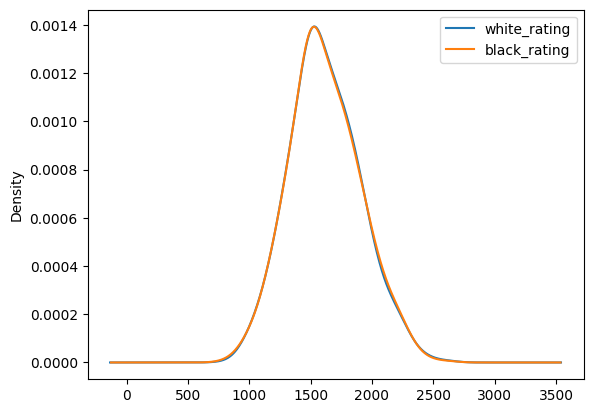

In [37]:
df_test[['white_rating','black_rating']].plot.kde(bw_method=0.3)

#### Funções utilitárias para processamento do FEN

In [8]:
def boardstate(fen):
    board = chess.Board(fen[0])
    fstr = str(fen[0])

    if board.has_kingside_castling_rights(chess.WHITE) == True:
        WCKI = 1
    else:
        WCKI = 0
    if board.has_queenside_castling_rights(chess.WHITE) == True:
        WCQ = 1
    else:
        WCQ = 0
    if board.is_check() == True:
        WCH = 1
    else:
        WCH = 0

    if board.has_kingside_castling_rights(chess.BLACK) == True:
        BCKI = 1
    else:
        BCKI = 0
    if board.has_queenside_castling_rights(chess.BLACK) == True:
        BCQ = 1
    else:
        BCQ = 0
    if board.was_into_check() == True:
        BCH = 1
    else:
        BCH = 0

    #f = [M, WCKI, WCQ, WCH, BCKI, BCQ, BCH]
    fw = [WCKI, WCQ, WCH]
    fb = [BCKI, BCQ, BCH]

    bstr = str(board)
    bstr = bstr.replace("p", "\ -1")
    bstr = bstr.replace("n", "\ -3")
    bstr = bstr.replace("b", "\ -4")
    bstr = bstr.replace("r", "\ -5")
    bstr = bstr.replace("q", "\ -9")
    bstr = bstr.replace("k", "\ -100")
    bstr = bstr.replace("P", "\ 1")
    bstr = bstr.replace("N", "\ 3")
    bstr = bstr.replace("B", "\ 4")
    bstr = bstr.replace("R", "\ 5")
    bstr = bstr.replace("Q", "\ 9")
    bstr = bstr.replace("K", "\ 100")
    bstr = bstr.replace(".", "\ 0")
    bstr = bstr.replace("\ ", ",")
    bstr = bstr.replace("'", " ")
    bstr = bstr.replace("\n", "")
    bstr = bstr.replace(" ", "")
    bstr = bstr[1:]
    bstr = eval(bstr)
    bstr = list(bstr)
    if "w" not in fstr:
        for i in range(len(bstr)):
            bstr[i] = bstr[i] * -1
        bstr.reverse()
        fs = fb
        fb = fw
        fw = fs


    BITBOARD = fw + fb + bstr


    return BITBOARD

In [9]:
def fen_to_board(fen):
    board = []
    for row in fen.split('/'):
        brow = []
        for c in row:
            if c == ' ':
                break
            elif c in '12345678':
                brow.extend( ['--'] * int(c) )
            elif c == 'p':
                brow.append( 'bp' )
            elif c == 'P':
                brow.append( 'wp' )
            elif c > 'Z':
                brow.append( 'b'+c.upper() )
            else:
                brow.append( 'w'+c )

        board.append( brow )
    return board

In [10]:
df_test.iloc[0, 6]

'R5nr/5p1p/2P1P2k/4p3/8/2P5/1P2BPPP/3QK1NR w K - 1 21'

In [11]:
fen_to_board(df_test.iloc[0,6])

[['wR', '--', '--', '--', '--', '--', 'bN', 'bR'],
 ['--', '--', '--', '--', '--', 'bp', '--', 'bp'],
 ['--', '--', 'wp', '--', 'wp', '--', '--', 'bK'],
 ['--', '--', '--', '--', 'bp', '--', '--', '--'],
 ['--', '--', '--', '--', '--', '--', '--', '--'],
 ['--', '--', 'wp', '--', '--', '--', '--', '--'],
 ['--', 'wp', '--', '--', 'wB', 'wp', 'wp', 'wp'],
 ['--', '--', '--', 'wQ', 'wK', '--', 'wN', 'wR']]

In [12]:
df_test.dropna(inplace=True)

In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14383 entries, 0 to 14382
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    14383 non-null  int64 
 1   id            14383 non-null  object
 2   turns         14383 non-null  int64 
 3   winner        14383 non-null  object
 4   white_rating  14383 non-null  int64 
 5   black_rating  14383 non-null  int64 
 6   position      14383 non-null  object
dtypes: int64(4), object(3)
memory usage: 786.7+ KB


### Conversão FEN para board numérica para as features de entrada



In [14]:
data_features = df_test[['position']]

data_features = data_features.apply(boardstate, axis=1)
data_features = data_features.apply(pd.Series)
print(data_features.head())

   0   1   2   3   4   5   6   7   8   9   ...  60  61  62  63  64  65   66  \
0   1   0   0   0   0   0   5   0   0   0  ...   1   1   0   0   0   9  100   
1   0   0   0   0   0   0   0   9   0   0  ...   1   1   5   0   0   0    0   
2   0   0   0   0   0   0   0   0  -5   0  ...   1   1   5   0   0   0    0   
3   0   0   0   0   0   0   0   0  -5   0  ...   1   0   5   0   3   0    0   
4   0   1   0   0   0   0   0   0  -5   0  ...   0   1   5   0   0   0  100   

   67   68  69  
0   0    3   5  
1   5  100   0  
2   5  100   0  
3   0  100   0  
4   0    0   0  

[5 rows x 70 columns]


### Conversão do ganhador do jogo para score de resultado:
* Branco vencedor - score = 10000
* Preto vencedor - score = -10000
* Empates - score = 0

In [15]:
def label_winner(row):
   if row['winner'] == 'white':
      return 10000
   if row['winner'] == 'black':
      return -10000
   return 0

data_labels = df_test.apply(label_winner, axis=1)
print(data_labels.head())

0    10000
1    10000
2    10000
3   -10000
4    10000
dtype: int64


In [16]:
import numpy as np
input2_columns = [0, 1, 2, 3, 4, 5]


inputboard = data_features.drop(columns=data_features.iloc[:, input2_columns])
inputboard = np.array(inputboard)
inputmeta = data_features.iloc[:, input2_columns]
inputmeta = np.array(inputmeta)

In [17]:
print(inputboard)

[[   5    0    0 ...    0    3    5]
 [   0    9    0 ...    5  100    0]
 [   0    0   -5 ...    5  100    0]
 ...
 [  -5   -3    0 ...    0  100    5]
 [   0    0 -100 ...    0    0    5]
 [   0    0    0 ...    0    0    0]]


In [18]:
print(inputmeta)

[[1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [19]:
data_features = data_features.to_numpy()
data_labels = data_labels.to_numpy()

#### Carregamento do modelo e inferência

In [26]:
import tensorflow as tf
import os
import numpy as np

# model_file = '/content/gdrive/MyDrive/IA006_Projeto/models/model.pkl'
model_file = './gdrive/MyDrive/comp_chess/data/model4.pkl'

data_model = joblib.load(model_file)

In [27]:
predictions = data_model.predict([(inputboard), (inputmeta)])

450/450 [==============================] - 20s 43ms/step


#### Verificação da acurácia do método utilizado para estimar a vitória/derrota do jogador.

In [28]:
# Conversão de predições
pred_new = np.full_like(predictions, 0)
count = 0
for i in predictions.flat:
  if (i > 0):
    pred_new[count] = 1
  elif (i < 0):
    pred_new[count] = -1
  else:
    pred_new[count] = 0
  count = count+1

pred_new = pred_new.transpose()

In [29]:
print(pred_new)

[[1. 1. 1. ... 1. 1. 1.]]


In [30]:
# Conversão de datalabels
labels_new = np.full_like(data_labels, 0)
count = 0
for i in data_labels.flat:
  if (i > 0):
    labels_new[count] = 1
  elif (i < 0):
    labels_new[count] = -1
  else:
    labels_new[count] = 0
  count = count+1

In [31]:
print(labels_new)

[ 1  1  1 ... -1  1 -1]


In [32]:
# Contagem do número de elementos iguais (Medida de acurácia do método)

print(np.sum(pred_new == labels_new) / pred_new.size)

0.6094695126190641


In [41]:
df_test.head()

,Unnamed: 0,id,turns,winner,white_rating,black_rating,position
0,2,mIICvQHh,61,white,1496,1500,R5nr/5p1p/2P1P2k/4p3/8/2P5/1P2BPPP/3QK1NR w K ...
1,3,kWKvrqYL,61,white,1439,1454,1Q3b1r/4kppp/2p5/3pP3/4b1n1/4PN2/1P2BPPP/R4RK1...
2,4,9tXo1AUZ,95,white,1523,1469,2r3k1/pp1b1ppp/3p1q2/1P2p3/P3P3/3Q1N2/2P2PPP/R...
3,8,dwF3DJHO,66,black,1439,1392,2r1r1k1/p4ppp/1q1p1n2/2pP4/2P1p3/PB3Q1P/1P3PP1...
4,9,afoMwnLg,119,white,1381,1209,2r2b1r/p4k1p/N1p1pnp1/8/3P1Bb1/6R1/PPP2P1P/R3K...


<Axes: xlabel='winner'>

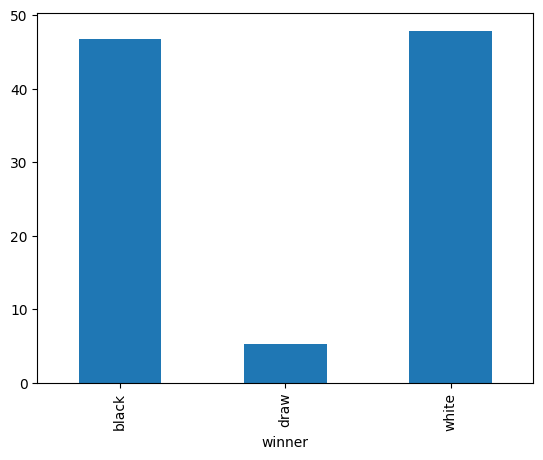

In [71]:
x = df_test.groupby(['winner']).count()
x = x/len(df_test) *100
x.id.plot(kind='bar')